## 1) Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cPickle as pickle
DATA_PATH = 'merged.pickle'

np.random.seed(42)

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
import keras

Using TensorFlow backend.


In [2]:
with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('labels.npy')

## 2) Preprocessing steps with data & features

In [3]:
# features which we want to delete
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

# columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [4]:
# features normalization
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [5]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), 
               data['_instantLumi_muons'].get_values()),
               data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]

In [6]:
data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]

In [7]:
del data['_luminosityBlock']
del data['_run']
del data['_instantLumi_minibias']
del data['_instantLumi_muons']
del data['_instantLumi_photons']

In [8]:
data['labels'] = pd.Series(labels, index=data.index)

In [9]:
data.head()

,minibias_PF_Px_mean,minibias_PF_Px_p1,minibias_PF_Px_p25,minibias_PF_Px_p50,minibias_PF_Px_p75,minibias_PF_Px_p99,minibias_PF_Px_std,minibias_PF_Py_mean,minibias_PF_Py_p1,minibias_PF_Py_p25,...,photons_photons_pt__q4_p99,photons_photons_pt__q4_std,photons_photons_pt__q5_mean,photons_photons_pt__q5_p1,photons_photons_pt__q5_p25,photons_photons_pt__q5_p50,photons_photons_pt__q5_p75,photons_photons_pt__q5_p99,photons_photons_pt__q5_std,labels
0,0.553982,0.121924,-2.377744,2.979489,3.999278,0.334869,-0.185235,-0.141756,-0.041391,-3.517199,...,0.771053,0.613178,0.671934,-0.115348,0.529921,0.626325,0.669504,0.781640,0.624168,0.0
1,0.618719,0.140093,-2.245878,3.164899,4.423358,0.350631,-0.162238,-0.141120,-0.119621,-3.520591,...,1.448301,0.720708,0.596897,-0.115348,0.500126,0.613411,0.762044,0.373972,0.564393,0.0
2,0.590468,0.089144,-2.267943,3.180846,4.379818,0.322018,-0.174552,-0.094414,-0.091330,-3.533495,...,0.315584,0.565043,0.521407,-0.115348,0.398654,0.593673,0.525674,1.095464,0.607292,0.0
3,0.563941,0.119073,-2.135948,3.271239,4.200118,0.282537,-0.179577,-0.155060,-0.146141,-3.579560,...,1.116072,0.778321,0.669518,-0.115348,0.659620,0.662089,0.603566,0.905891,0.494840,0.0
4,0.512639,0.077763,-2.699199,2.974805,4.191212,0.289252,-0.170892,-0.122369,-0.076968,-3.478975,...,0.397704,0.620604,0.533768,-0.115348,0.444284,0.585253,0.609742,1.004260,0.574727,0.0


In [11]:
from sklearn.model_selection import train_test_split

df = np.array(data)

X_train, X_test = train_test_split(df, test_size=0.2)

In [15]:
X_val = X_train

X_train, X_val = train_test_split(X_train, test_size=0.2)

In [16]:
print(X_train.shape,
X_test.shape,
X_val.shape)

((16668, 2695), (5210, 2695), (4168, 2695))


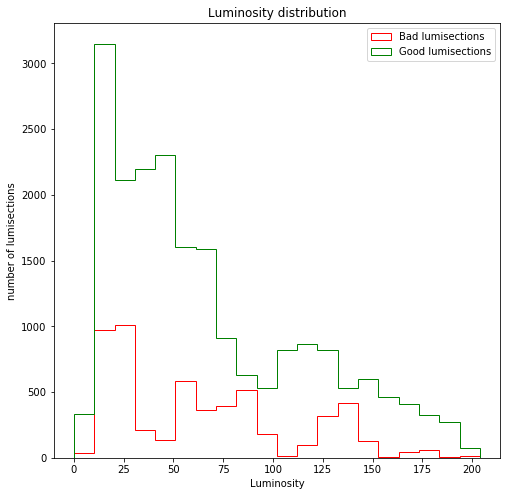

In [17]:
plt.figure(figsize=(8, 8))

plt.hist(
    [lumi[labels == 1.0], lumi[labels == 0.0]],
    label=['Good lumisections', 'Bad lumisections'],
    color=['green', 'red'],
    bins=20,
    histtype='step'
)

plt.legend(loc='upper right')

plt.title('Luminosity distribution')
plt.xlabel('Luminosity')
plt.ylabel('number of lumisections')
plt.show()

## 3) Build the network/autoencoder


In [18]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.activations import relu
from keras.regularizers import l2
from keras.initializers import Orthogonal

## 3.1) encoded = 512, 5 layers

In [59]:
def make_autoencoder():
    leaky_relu = lambda x: relu(x, alpha=0.05)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(2695,))
    
    dense1 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(inputs)
    
    dense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense1)
    
    

    encoded = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
        name='encoded'
    )(dense2)
    
    
    
    dedense1 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)
    
    dedense2 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense1)
    
    outputs = Dense(2695)(dedense2)
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [60]:
ae, ae_encoder = make_autoencoder()

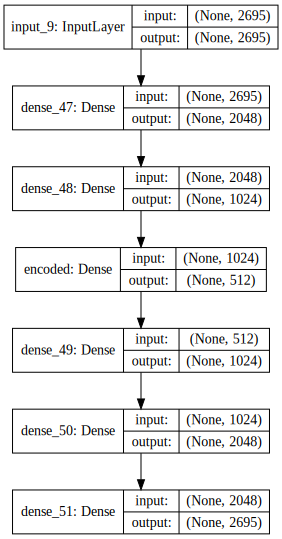

In [61]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae, show_shapes=True).create(prog='dot', format='svg'))

In [62]:
from keras.optimizers import Adadelta
from keras.objectives import MSE

In [63]:
ae.compile(optimizer=Adadelta(), loss=MSE)

In [64]:
ae.fit(X_val, X_val, epochs=12)

Epoch 1/12
4168/4168 [==============================] - 70s - loss: 0.3151      

In [65]:
X_pred = ae.predict(X_test)

In [66]:
print('Test MSE:', np.mean((X_pred - X_test) ** 2))

('Test MSE:', 0.182697803766841)


## 3.2) encoded 128, 5 layers

In [29]:
def make_autoencoder2():
    leaky_relu = lambda x: relu(x, alpha=0.05)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(2695,))
    
    dense1 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(inputs)
    
    dense2 = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense1)
    
    

    encoded = Dense(
        128, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
        name='encoded'
    )(dense2)
    
    
    
    dedense1 = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)
    
    dedense2 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense1)
    
    outputs = Dense(2695)(dedense2)
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [30]:
ae2, ae_encoder2 = make_autoencoder2()

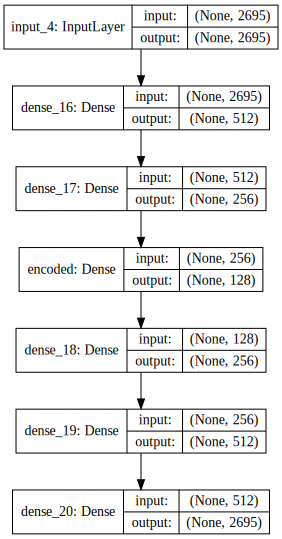

In [41]:
SVG(model_to_dot(ae2, show_shapes=True).create(prog='dot', format='svg'))

In [34]:
ae2.compile(optimizer=Adadelta(), loss=MSE)

In [35]:
ae2.fit(X_val, X_val, epochs=12)

Epoch 1/12
4168/4168 [==============================] - 11s - loss: 0.3766      

In [36]:
X_pred = ae2.predict(X_test)

print('Test MSE:', np.mean((X_pred - X_test) ** 2))

('Test MSE:', 0.2151108058100516)


## 3.3) encoded 128, 7layers

In [67]:
def make_autoencoder3():
    leaky_relu = lambda x: relu(x, alpha=0.05)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(2695,))
    
    dense1 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(inputs)
    
    dense2 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense1)
    
    dense3 = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense2)
    
    
    encoded = Dense(
        128, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
        name='encoded'
    )(dense3)
    

    dedense1 = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)
    
    dedense2 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense1)
    
    dedense3 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense2)
    
    outputs = Dense(2695)(dedense3)
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [69]:
ae3, ae_encoder3 = make_autoencoder3()

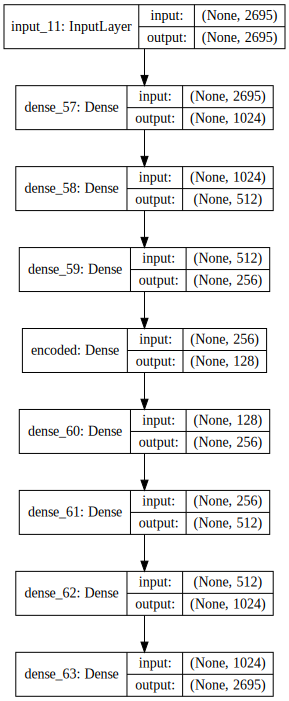

In [70]:
SVG(model_to_dot(ae3, show_shapes=True).create(prog='dot', format='svg'))

In [71]:
ae3.compile(optimizer=Adadelta(), loss=MSE)

In [72]:
ae3.fit(X_val, X_val, epochs=12)

Epoch 1/12
4168/4168 [==============================] - 31s - loss: 0.3876      

In [73]:
X_pred = ae3.predict(X_test)

print('Test MSE:', np.mean((X_pred - X_test) ** 2))

('Test MSE:', 0.20716124755107934)


## 3.4) encoded 256, 7 layers

In [74]:
def make_autoencoder4():
    leaky_relu = lambda x: relu(x, alpha=0.05)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(2695,))
    
    dense1 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(inputs)
    
    dense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense1)
    
    dense3 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense2)
    
    
    encoded = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
        name='encoded'
    )(dense3)
    

    dedense1 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)
    
    dedense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense1)
    
    dedense3 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense2)
    
    outputs = Dense(2695)(dedense3)
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [75]:
ae4, ae_encoder4 = make_autoencoder4()

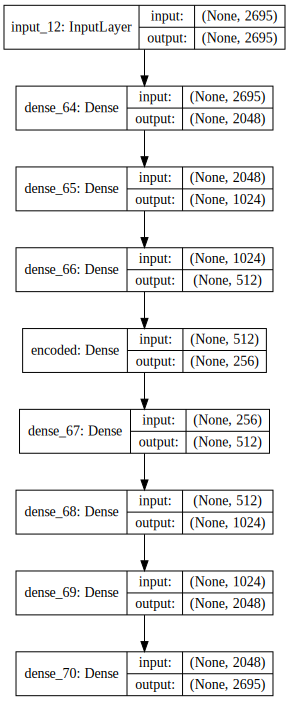

In [76]:
SVG(model_to_dot(ae4, show_shapes=True).create(prog='dot', format='svg'))

In [77]:
ae4.compile(optimizer=Adadelta(), loss=MSE)

In [78]:
ae4.fit(X_val, X_val, epochs=12)

Epoch 1/12
4168/4168 [==============================] - 67s - loss: 0.3629      

In [79]:
X_pred = ae4.predict(X_test)

print('Test MSE:', np.mean((X_pred - X_test) ** 2))

('Test MSE:', 0.19510195467050204)


## 3.5) encoded 256, 5 layers

In [80]:
def make_autoencoder5():
    leaky_relu = lambda x: relu(x, alpha=0.05)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(2695,))
    
    dense1 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(inputs)
    
    dense2 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense1)
    
    

    encoded = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
        name='encoded'
    )(dense2)
    
    
    
    dedense1 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)
    
    dedense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense1)
    
    outputs = Dense(2695)(dedense2)
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [81]:
ae5, ae_encoder5 = make_autoencoder5()

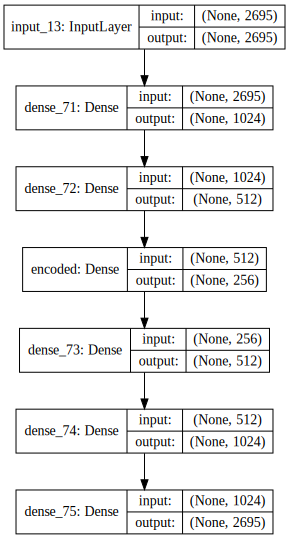

In [82]:
SVG(model_to_dot(ae5, show_shapes=True).create(prog='dot', format='svg'))

In [83]:
ae5.compile(optimizer=Adadelta(), loss=MSE)

In [84]:
ae5.fit(X_val, X_val, epochs=12)

Epoch 1/12
4168/4168 [==============================] - 30s - loss: 0.3503      

In [85]:
X_pred = ae5.predict(X_test)

print('Test MSE:', np.mean((X_pred - X_test) ** 2))

('Test MSE:', 0.1902985832065841)


## 4) Comparison of models

In [92]:
print( 'encoded 512, 5 layers Test MSE: 0.182697803766841') 
print ('encoded 256, 5 layers Test MSE: 0.1902985832065841')
print  ('encoded 256, 7 layers Test MSE: 0.19510195467050204')
print  ('encoded 128, 5 layers Test MSE: 0.2151108058100516')
print  ('encoded 128, 7layers  Test MSE: 0.20716124755107934')

encoded 512, 5 layers Test MSE: 0.182697803766841
encoded 256, 5 layers Test MSE: 0.1902985832065841
encoded 256, 7 layers Test MSE: 0.19510195467050204
encoded 128, 5 layers Test MSE: 0.2151108058100516
encoded 128, 7layers  Test MSE: 0.20716124755107934
